In [15]:
import pandas as pds, numpy as np, tensorflow as tf
print(tf.__version__)
import nltk, itertools
import matplotlib.pyplot as plt

2.4.1


# Define methods:

In [16]:
#ensures the dataframe is 50% legit 50% phish:
def get5050(df):
    nPhish = len(df[df['label']==1])
    nLegit = len(df[df['label']==0])
    
    nMin = min(nPhish, nLegit)
    #select the nMin phish-rows
    sPhish = df[df['label']==1].sample(n=nMin)
    #select the nMin legit-rows
    sLegit = df[df['label']==0].sample(n=nMin)
    
    if(len(sPhish)!=len(sLegit)):
        print("Error laoding 50/50 dataset")
        
    return sLegit.append(sPhish,ignore_index=True)

In [17]:
procURL = False
def proc_urls(df, splitter):    
    if(not isinstance(splitter,nltk.tokenize.regexp.RegexpTokenizer)):
        raise TypeError("splitter of proc_url must be nltk RegexpTokenizer")
    
    if(procURL==False):
        return df
    
    newUrls = []
    for url in df["url"]:
        url = str(url).lower()

        url.encode('utf-8', 'ignore').decode()
        urlSplit = [clean.strip() for clean in splitter.tokenize(url) if(clean.strip()!="")]
    
        newUrls += " ".join(urlSplit)
    df["url"] = newUrls
    return df

In [18]:
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    NOTE: Modified from output of scikit learn!  
    EXPECTS: [[tp, fp],[fn,tn]]
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    #plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    #Normalize the confusion matrix.
    #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    colm = np.array([["white","black"],["black","white"]])
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=colm[i,j])

    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('Truth')
  
    return figure

# Lets create our own pipeline for fine tuning:

### Do the setup for the model:

In [19]:
import transformers
from transformers import BertTokenizer, ElectraTokenizerFast, RobertaTokenizerFast, TFElectraForSequenceClassification, TFBertForSequenceClassification, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english" #this is the checkpoint (pretrained model) we are using for the example.
tokenizer = BertTokenizer.from_pretrained(checkpoint) #setup the tokenizer. We need to pass it the checkpoint because hf models need a specific mapping of word-ids

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


# Let's create/load a CSV into a dataset object:

In [20]:
from sklearn.model_selection import train_test_split

#load the csv:
dfTrain = pds.read_csv("../../data/compiled/allTrain.csv", index_col = 0)
dfTest = pds.read_csv("../../data/compiled/allTest.csv", index_col = 0)
dfLegit = dfTrain[dfTrain["label"]==0]
dfPhish = dfTrain[dfTrain["label"]==1]

dfTrainFixed = get5050(dfTrain)
dfTestFixed = get5050(dfTest)
splitter=nltk.RegexpTokenizer("\d+|[a-z]+|\W")
dfTrainFixed = proc_urls(dfTrainFixed,splitter)
dfTestFixed = proc_urls(dfTestFixed,splitter)

display((len(dfTrainFixed), len(dfTrain)))
display((len(dfTestFixed), len(dfTest)))

(24310, 60775)

(6078, 15195)

In [21]:
dfTrainFixed

,label,url
0,0,erobooker.com/nozarashisatoru/usaginokamentanh...
1,0,www.elearningmarketplace.co.uk/product-categor...
2,0,blijmetjeboekhouding.nl/aanbevelingen/
3,0,www.exotickenya.com/escorts-from/ongata-rongai...
4,0,www.naturallyheaventherapy.co.uk/online-store/...
...,...,...
24305,1,linktr.ee/PUBGM.UCfree
24306,1,caspianglobalservices.com/fonts/.hennessy/
24307,1,hannetjiefaurie1.creatorlink.net/
24308,1,halifax-security-login.com/


In [22]:
x = list(dfTrainFixed["url"])
y = list(dfTrainFixed["label"])

#X_train, X_val, y_train, y_val
xTR, xVA, yTR, yVA = train_test_split(x,y, shuffle=True, test_size=0.2)

### Tokenize:

In [23]:
tEncoding = tokenizer(xTR, truncation=True, padding=True)
vEncoding = tokenizer(xVA, truncation=True, padding=True)

In [24]:
trainDS = tf.data.Dataset.from_tensor_slices((dict(tEncoding),yTR))
valDS = tf.data.Dataset.from_tensor_slices((dict(vEncoding),yVA))

# Lets do some Training!

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [26]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support( \
                           labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [27]:
#OUTPUT_DIR="/s/fir/e/nobackup/Fresh-Phish/transformer_exps/progs/Trained Models"
OUTPUT_DIR="../proj/progs/TrainedModels"
training_args = TFTrainingArguments(output_dir=OUTPUT_DIR,            # output directory
            evaluation_strategy="steps",      # evaluation strategy
            num_train_epochs=3,               # total number of training epochs
            per_device_train_batch_size=16,  # batch size per device during training
            per_device_eval_batch_size=16,   # batch size for evaluation
            per_gpu_train_batch_size=16,
            per_gpu_eval_batch_size=16,
            warmup_steps=10000,  # number of warmup steps for learning rate scheduler
            weight_decay=0.01,   # strength of weight decay
            learning_rate=8.e-5, # Adam learning rate
            adam_epsilon=1.e-6)  # Adam epsilon

with training_args.strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased-finetuned-sst-2-english")
    
trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=trainDS,               # training dataset
    eval_dataset=valDS,                  # evaluation dataset
    compute_metrics=compute_metrics      # evaluation metrics
)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFBertForSequenceClassification: ['distilbert', 'pre_classifier', 'dropout_19']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/s/chopin/

In [28]:
import time
start = time.time()
trainer.train()
stop = time.time()
print("Fine-Tuning Time: {:.2f}".format(stop-start))

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
2021-11-20 21:12:38.917431: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
        dim {
          size: 512
        }
      }
      shape {
      }
   

Fine-Tuning Time: 1620.58


# Let's get the results:

In [29]:
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result['eval_accuracy']))

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
2021-11-20 21:39:39.499819: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: D

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Accuracy: 0.9730674342105263


In [30]:
model_result

{'eval_loss': 0.07906411196056165,
 'eval_accuracy': 0.9730674342105263,
 'eval_f1': 0.9724384599200505,
 'eval_precision': 0.9788225328250741,
 'eval_recall': 0.9661371237458194}


### Looks good. Lets predict:

In [31]:
xTE = list(dfTestFixed["url"])
yTE = list(dfTestFixed["label"])
#create the test dataset:

testEncoding = tokenizer(xTE,truncation=True, padding=True)
testDS=tf.data.Dataset.from_tensor_slices((dict(testEncoding), yTE))

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
2021-11-20 22:00:25.539418: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:656] In AUTO-mode, and switching to DATA-based sharding, instead of FILE-based sharding as we cannot find appropriate reader dataset op(s) to shard. Error: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
      type: DT_INT32
    }
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 512
        }
      }
      shape

Training Bal Accuracy: 95.986%


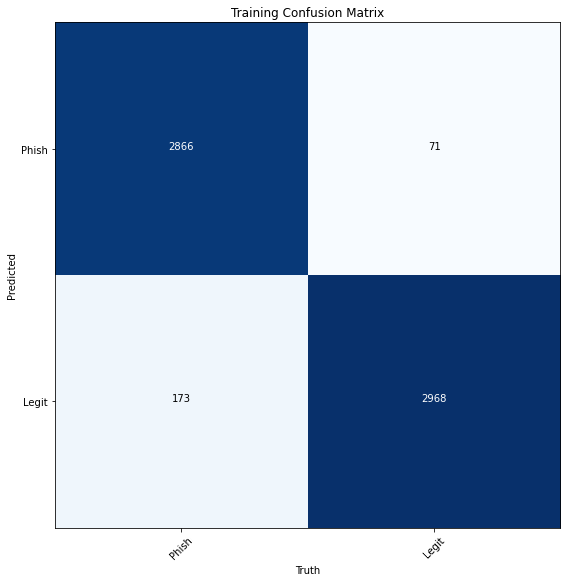

In [32]:
pred_train = trainer.predict(testDS)
trlabels = pred_train.label_ids
trpreds = pred_train.predictions.argmax(-1)


tn, fp, fn, tp = confusion_matrix(trlabels, trpreds).ravel()
traccuracy = (tp + tn)/(tn + tp + fn + fp)
traccuracyB = ((tp/(tp+fn) + tn/(fp+tn))*0.5)
print("Training Bal Accuracy: {:.3f}%".format(traccuracyB*100.))
cmatrix = np.array([[tp, fp],[fn, tn]])
disp = plot_confusion_matrix(cmatrix, ['Phish','Legit'], cTitle='Training Confusion Matrix')

In [33]:
tf.__version__

'2.4.1'

In [34]:
np.array([10 * np.random.uniform(), 0.0])

array([3.74540119, 0.        ])